In [24]:
!pip install "line_profiler[ipython]" ipython==8.5.0 ffmpeg-python imutils==0.5.4 sahi scikit-learn supervision openai ipywidgets

In [25]:
# This experiment depends on specific files.
video_path = "/home/luis/workspace/vacocam_render/source/prerender.mp4"
detections_path = "/home/luis/workspace/vacocam_render/experiments/vacocam/2024_04_02-2_claude3_5sec/source/track/prerender_detections_declustered.npy"

In [26]:
import hashlib

md5 = hashlib.md5()

with open(video_path, "rb") as f:
    for chunk in iter(lambda: f.read(4096), b""):
        md5.update(chunk)

assert md5.hexdigest() == "6d30279ea8ab9754c748d5752d97a027", "The video file is not the correct one."

md5 = hashlib.md5()
with open(detections_path, "rb") as f:
    for chunk in iter(lambda: f.read(4096), b""):
        md5.update(chunk)

assert md5.hexdigest() == "0631148b034011bb4fd463ee9ab9323e", "The detections file is not the correct one."

print("All files are correct.")

All files are correct.


In [27]:
# set the experiment variables

seconds = 3

#### First, generate a presentation for every section in our video. This includes loading the cleaned up ball detections for the video

In [28]:
import supervision as sv
import cv2
from cv2 import VideoCapture
import os
import numpy as np

from detections import load_detections, Detections
from typing import Union

_, detections = load_detections(detections_path)

video_info = sv.VideoInfo.from_video_path(video_path)

framerate = video_info.fps
total_frames = video_info.total_frames or 0

video_height = video_info.height
video_width = video_info.width

frame_indices = [(i * seconds * framerate, (i + 1) * seconds * framerate) for i in range(int(total_frames / (seconds * framerate)))]
if frame_indices[-1][1] != total_frames:
    frame_indices.append((frame_indices[-1][1], total_frames))

def sample_video_section(cap: VideoCapture, start, end, samples=1) -> Union[np.ndarray, list[np.ndarray]]:

    section_duration = end - start

    if section_duration < samples:
        raise Exception("Not enough frames in the section to sample")
    if samples < 1:
        raise Exception("Samples must be a positive integer")

    # section_split: list[int] = np.linspace(start, end, samples + 1, endpoint=False)[1:].astype(int).tolist()
    section_split: list[int] = np.linspace(start, end, samples * 2, endpoint=False)[1:][::2].astype(int).tolist()

    print(f"Section duration: {section_duration}")
    print(f"Samples: {samples}")
    print(f"Section start: {start}")
    print(f"Section end: {end}")
    print(f"Section split: {section_split}")

    sampled_frames = []

    for frame_number in section_split:
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
        ret, frame = cap.read()
        if not ret:
            raise Exception("Error reading video")
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        sampled_frames.append(frame)

    if samples == 1:
        return sampled_frames[0]
    else:
        return sampled_frames


loaded 112300 detections from /home/luis/workspace/vacocam_render/experiments/vacocam/2024_04_02-2_claude3_5sec/source/track/prerender_detections_declustered.npy


In [29]:
# cluster detections and find overlaps

%load_ext autoreload
%autoreload 2

from tracking import cluster_detections, get_artifact_id

# for video generation
from tracking import present_section
import numpy as np
from PIL import Image
from io import BytesIO

from tqdm import tqdm

overlaps = {}

detections_sum = 0
clustered_sum = 0

cap = cv2.VideoCapture(video_path)

for start, end in tqdm(frame_indices):
    section_detections = detections[start:end]
    clustered_detections: dict[int, list[Detections]] = cluster_detections(section_detections, image_width=video_info.width, image_height=video_info.height, preset="play")

    clustered_detections_minus_noise: dict[int, list[Detections]] = { key: detections for key, detections in clustered_detections.items() if key != -1 }

    detections_sum_section = sum([len(detections) for detections in section_detections])
    clustered_sum_section = sum([len(detections) for detections_l in clustered_detections_minus_noise.values() for detections in detections_l])

    detections_sum += detections_sum_section
    clustered_sum += clustered_sum_section

    # find clusters start and ends
    start_ends: dict[int, tuple[int, int]] = { key: (0, 0) for key in clustered_detections_minus_noise.keys() }

    for key, c_detections in clustered_detections_minus_noise.items():
        # find start of the cluster, meaning the index of the first detection that is not empty. (len(detection) > 0)
        cluster_start = 0
        for i, detection in enumerate(c_detections):
            if len(detection) > 0:
                cluster_start = i
                break
        # find end of the cluster, meaning the index of the last detection that is not empty. (len(detection) > 0)
        cluster_end = 0
        for i, detection in enumerate(reversed(c_detections)):
            if len(detection) > 0:
                cluster_end = len(c_detections) - i
                break
        start_ends[key] = (cluster_start, cluster_end)
    
    # now find any overlapping clusters
    overlapping_clusters = {}

    for key1, (start1, end1) in start_ends.items():
        for key2, (start2, end2) in start_ends.items():
            if key1 != key2 and start1 < end2 and end1 > start2:
                overlap = min(end1, end2) - max(start1, start2)

                if (key1, key2) in overlapping_clusters or (key2, key1) in overlapping_clusters:
                    continue
                if overlap < min(end1 - start1, end2 - start2) * 0.5:
                    continue
                if end1 - start1 < 15 or end2 - start2 < 15 or overlap < 15:
                    continue

                overlapping_clusters[(key1, key2)] = {
                    "overlap": min(end1, end2) - max(start1, start2),
                    "clusters": {
                        key1: clustered_detections_minus_noise[key1],
                        key2: clustered_detections_minus_noise[key2]
                    },
                    "bounds": {
                        key1: (start + start1, start + end1),
                        key2: (start + start2, start + end2)
                    },
                }


    if len(overlapping_clusters) > 0:
        overlaps[(start, end)] = overlapping_clusters

print("[VacomCam] Done finding overlaps")
print("[VacomCam] Found {} overlaps".format(sum([len(value) for value in overlaps.values()])))

print("[VacomCam] Total detections: {}".format(detections_sum))
print("[VacomCam] Total clustered detections: {}".format(clustered_sum))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


100%|██████████| 1248/1248 [00:08<00:00, 144.05it/s]

[VacomCam] Done finding overlaps
[VacomCam] Found 25 overlaps
[VacomCam] Total detections: 43305
[VacomCam] Total clustered detections: 40905


In [30]:
# save presented sections to disk

%load_ext autoreload
%autoreload 2

import numpy as np
from PIL import Image
from io import BytesIO

from tracking import present_section, save_section_presentation

# print overlaps ordered by overlap time descendent
overlaps = { key: value for key, value in sorted(overlaps.items(), key=lambda item: sum([va["overlap"] for va in item[1].values()]), reverse=True) }

# lets also make a video of the overlaps for easier viewing
v_out = cv2.VideoWriter("overlaps.mp4", cv2.VideoWriter_fourcc(*'mp4v'), framerate, (1920, 1080))

for (section_start, section_end), overlapping_clusters in overlaps.items():
    formatted_start = f"{int(section_start / framerate / 60)}:{int(section_start / framerate % 60)}"
    formatted_end = f"{int(section_end / framerate / 60)}:{int(section_end / framerate % 60)}"

    print(f"{formatted_start} - {formatted_end}")

    for (key1, key2), overlap_data in overlapping_clusters.items():
        start1, end1 = overlap_data["bounds"][key1]
        start2, end2 = overlap_data["bounds"][key2]

        overlap_start = min(start1, start2)
        overlap_end = max(end1, end2)

        print(f"\t{key1} - {key2} ({overlap_data['overlap']} frames overlap)")
        formatted_start = f"{int(overlap_start / framerate / 60)}:{int(overlap_start / framerate % 60)}"
        formatted_end = f"{int(overlap_end / framerate / 60)}:{int(overlap_end / framerate % 60)}"
        print(f"\t\t{formatted_start} - {formatted_end}")

        artifact_id = get_artifact_id(video_path, overlap_start, overlap_end, framerate)

        sample = sample_video_section(cap, section_start, section_end, samples=3)

        section_imgs, section_metadata = present_section(sample, overlap_data["clusters"], version="v3")
        
        save_section_presentation(artifact_id, section_imgs, section_metadata)

        if not isinstance(section_imgs, list):
            section_imgs = [section_imgs]

        for section_img in section_imgs:
            video_frame = np.array(Image.open(BytesIO(section_img)))
            v_out.write(cv2.cvtColor(video_frame, cv2.COLOR_RGB2BGR))

v_out.release()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
5:39 - 5:42
	0 - 1 (58 frames overlap)
		5:39 - 5:42
Section duration: 90
Samples: 3
Section start: 10170
Section end: 10260
Section split: [10185, 10215, 10245]
[tracking] Splitting the section into 3 parts
[tracking] Split indices: [(0, 30), (30, 60), (60, 90)]
[tracking] Section length: 90
5:33 - 5:36
	0 - 1 (44 frames overlap)
		5:33 - 5:36
Section duration: 90
Samples: 3
Section start: 9990
Section end: 10080
Section split: [10005, 10035, 10065]
[tracking] Splitting the section into 3 parts
[tracking] Split indices: [(0, 30), (30, 60), (60, 90)]
[tracking] Section length: 90
11:45 - 11:48
	0 - 1 (41 frames overlap)
		11:45 - 11:48
Section duration: 90
Samples: 3
Section start: 21150
Section end: 21240
Section split: [21165, 21195, 21225]
[tracking] Splitting the section into 3 parts
[tracking] Split indices: [(0, 30), (30, 60), (60, 90)]
[tracking] Section length: 90
57:36 - 57:39
	1 - 2 (41 fr

#### Cleanup and setup

Now that the sections have been generated, go and manually delete the ones you dont need. (image and metadata)

Then, run the code below:

In [52]:
import os
import matplotlib.pyplot as plt
from typing import Optional

pngs = [f for f in os.listdir("./track/presentation") if f.endswith(".png")]
pngs = [os.path.basename(f) for f in pngs]

# remove the _\d+.png part
artifact_ids = [png.rsplit("_", 1)[0] for png in pngs]
# remove duplicates
artifact_ids = list(dict.fromkeys(artifact_ids))

if not os.path.exists("./track/ground_truth"):
    os.makedirs("./track/ground_truth")

for artifact_id in artifact_ids:
    csv = artifact_id + ".csv"

    if not os.path.isfile(os.path.join("./track/ground_truth", csv)):
        open(os.path.join("./track/ground_truth", csv), "w").close()

def load_ground_truth(artifact_id) -> Optional[dict[str, bool]]:
    ## example ground truth file:
    ## A, True
    ## B, False

    output_dir = os.path.join(os.getcwd(), "track", "ground_truth")

    file_path = os.path.join(output_dir, artifact_id + ".csv")

    if os.path.exists(file_path):
        if os.path.getsize(file_path) == 0:
            return None

        with open(file_path, "r") as f:
            file_contents = f.read()
        
        res = {}

        for line in file_contents.split("\n"):
            if line.strip() != "":
                key = line.split(",")[0].strip().upper()
                value = line.split(",")[1].strip()

                res[key] = value in ["True", "true", "1", "yes", "Yes", "YES"]

        return res
    else:
        print(f"[load_ground_truth] File {file_path} does not exist")
        
        return None

def calc_score(ground_truth: dict[str, bool], response: Union[dict[str, bool], None]) -> float:
    if len(ground_truth) == 0:
        return 0
    if response is None:
        return 0

    score = 0
    for key in ground_truth:
        if key not in response.keys():
            print(f"[calc_score] Key {key} not in response, skipping")
            continue

        if ground_truth[key] == response[key]:
            score += 1
    
    return score / len(ground_truth)

def calc_scores(responses: dict[str, dict[str, bool]]):
    ground_truths = [{}] * len(artifact_ids)
    scores = [0.0] * len(artifact_ids)

    for idx, artifact_id in enumerate(artifact_ids):
        ground_truth = load_ground_truth(artifact_id)

        if ground_truth is None:
            print(f"Ground truth for {artifact_id} does not exist, skipping")
            continue
        else:
            print(f"Loaded ground truth for {artifact_id}")

        ground_truths[idx] = ground_truth

        response = responses[artifact_id]

        score = calc_score(ground_truth, response)
    
        print(f"Expected: [{ground_truth}]")
        print(f"Received: [{response}]")
        print(f"Score: {score}\n")

        scores[idx] = score

    print(f"Overall score: {sum(scores) / len(scores)}")

    # show a dot for every data point int the graph, and also a line connecting them
    # also show the id next to the dot, rotated 90 degrees
    plt.plot(scores, 'o-')

    for idx, score in enumerate(scores):
        plt.text(idx, score, artifact_ids[idx], ha='center', va='center', fontsize=8, rotation=90)

    plt.show()

#### Now, call gpt4 vision for each presented section in our dataset

In [57]:
%load_ext autoreload
%autoreload 2

import time
from tracking import load_section_presentation, load_gpt4_response, save_gpt4_response, parse_gpt4_response, ask_gippity_for_primary_clusters
from tracking import encode_image
from gpt4 import submit_image
from tqdm import tqdm

responses: dict[str, dict[str, bool]] = {}

pbar = tqdm(artifact_ids)

for idx, artifact_id in enumerate(pbar):
    section_imgs, section_metadata = load_section_presentation(artifact_id)

    if section_imgs is None or section_metadata is None:
        raise Exception("Error loading section presentation")

    retry_loaded = False

    loaded_response = load_gpt4_response(artifact_id)
    loaded_response_parsed = parse_gpt4_response(loaded_response)

    loaded_ground_truth = load_ground_truth(artifact_id)

    if loaded_ground_truth is not None:
        score = calc_score(loaded_ground_truth, loaded_response_parsed)

        if score != 1:
            retry_loaded = True

    if loaded_response_parsed is None or retry_loaded:
        pbar.set_description(f"Submitting section ({artifact_id})")
        # response = ask_gippity_for_primary_clusters(section_imgs, section_metadata, version="v4")

        if type(section_imgs) == list:
            encoded_images = [encode_image(image) for image in section_imgs]
        else:
            encoded_images = [encode_image(section_imgs)]

        response = submit_image(encoded_images, section_metadata, version="v4")

        if response is None:
            print("Response was None, SAVING EMPTY RESPONSE")

        save_gpt4_response(artifact_id, response)

        response_parsed = parse_gpt4_response(response)

        if response_parsed is None:
            print("Response could not be parsed")
            continue

        responses[artifact_id] = response_parsed
    else:
        pbar.set_description(f"Loaded response from cache ({artifact_id})")

        responses[artifact_id] = loaded_response_parsed

    # sleep for 15 seconds to avoid rate limiting
    # time.sleep(15)

print("[VacomCam] Done processing video sections")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Processing video sections:00<?, ?it/s]
Processing video sectionse (prerender.mp4_42-45_42-48):   0%|          | 0/25 [00:00<?, ?it/s]
Loaded response from cache (prerender.mp4_42-45_42-48)
Submitting section (prerender.mp4_02-12_02-14):   0%|          | 0/25 [00:00<?, ?it/s]

Processing video sections
Loaded response from cache (prerender.mp4_42-45_42-48)
Processing video sectionsnder.mp4_02-12_02-14):   8%|▊         | 2/25 [00:09<01:48,  4.72s/it]
Loaded response from cache (prerender.mp4_42-45_42-48)
Submitting section (prerender.mp4_02-12_02-14)
Processing video sectionsnder.mp4_57-36_57-39):   8%|▊         | 2/25 [00:09<01:48,  4.72s/it]
Loaded response from cache (prerender.mp4_42-45_42-48)
Submitting section (prerender.mp4_02-12_02-14)
Processing video sectionsnder.mp4_57-36_57-39):  12%|█▏        | 3/25 [00:18<02:27,  6.69s/it]
Loaded response from cache (prerender.mp4_42-45_42-48)
Submitting section (prerender.mp4_02-12_02-14)
Submitting section (prerender.mp4_57-36_57-39)
Processing video sectionsnder.mp4_05-36_05-37):  12%|█▏        | 3/25 [00:18<02:27,  6.69s/it]
Loaded response from cache (prerender.mp4_42-45_42-48)
Submitting section (prerender.mp4_02-12_02-14)
Submitting section (prerender.mp4_57-36_57-39)
Processing video sectionsnder.mp4_05-

[VacomCam] Done processing video sections


In [55]:
print(responses)

{'prerender.mp4_42-45_42-48': {'A': True, 'B': False}, 'prerender.mp4_02-12_02-14': {'A': False, 'B': True}, 'prerender.mp4_57-36_57-39': {'B': False, 'C': True}, 'prerender.mp4_05-36_05-37': {'A': True, 'B': False}, 'prerender.mp4_06-17_06-18': {'B': False, 'D': True}, 'prerender.mp4_02-18_02-20': {'B': True, 'C': False}, 'prerender.mp4_42-43_42-45': {'A': False, 'B': True}, 'prerender.mp4_53-00_53-03': {'A': True, 'B': False}, 'prerender.mp4_17-39_17-42': {'A': True, 'B': False}, 'prerender.mp4_50-15_50-18': {'A': True, 'B': False}, 'prerender.mp4_05-42_05-42': {'A': True, 'B': False}, 'prerender.mp4_13-24_13-27': {'A': True, 'B': False}, 'prerender.mp4_06-21_06-24': {'A': True, 'B': False}, 'prerender.mp4_52-33_52-36': {'A': True, 'B': False}, 'prerender.mp4_26-27_26-29': {'A': True, 'B': False}, 'prerender.mp4_02-33_02-36': {'A': False, 'B': True}, 'prerender.mp4_60-30_60-31': {'A': False, 'B': True}, 'prerender.mp4_05-33_05-36': {'A': True, 'B': False}, 'prerender.mp4_12-33_12-34'

Loaded ground truth for prerender.mp4_42-45_42-48
Expected: [{'A': True, 'B': False}]
Received: [{'A': True, 'B': False}]
Score: 1.0

Loaded ground truth for prerender.mp4_02-12_02-14
Expected: [{'A': True, 'B': False}]
Received: [{'A': True, 'B': False}]
Score: 1.0

Loaded ground truth for prerender.mp4_57-36_57-39
Expected: [{'B': True, 'C': False}]
Received: [{'B': True, 'C': False}]
Score: 1.0

Loaded ground truth for prerender.mp4_05-36_05-37
Expected: [{'B': True, 'A': False}]
Received: [{'A': True, 'B': False}]
Score: 0.0

Loaded ground truth for prerender.mp4_06-17_06-18
Expected: [{'B': False, 'D': False}]
Received: [{'B': True, 'D': False}]
Score: 0.5

Loaded ground truth for prerender.mp4_02-18_02-20
Expected: [{'B': True, 'C': False}]
Received: [{'B': True, 'C': False}]
Score: 1.0

Loaded ground truth for prerender.mp4_42-43_42-45
Expected: [{'A': True, 'B': False}]
Received: [{'A': False, 'B': True}]
Score: 0.0

Loaded ground truth for prerender.mp4_53-00_53-03
Expected: [

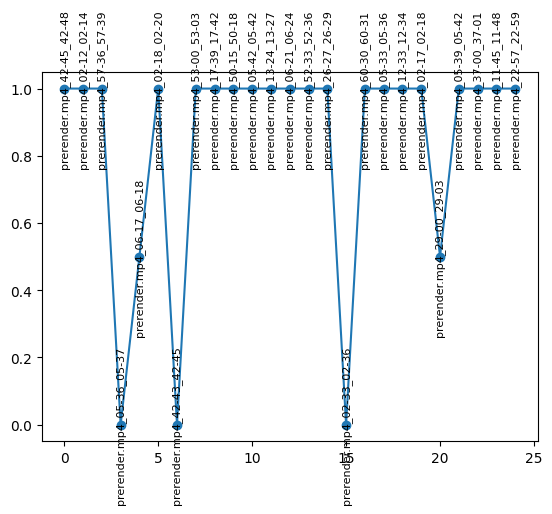

In [58]:
#2_original_prompt
calc_scores(responses)